# Лабораторная работа №3. Бинарная сегментация избражений

В работе реализована тренировка сверточной нейронной сети Unet для сегментации левого желудочка на УЗИ изображениях сердца.

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Директория датасета состоит из двух директорий, в одной лежат изображения, в другой лежат разметка.

In [12]:
path = '/home/vasily/datasets/toys/segmentation/ultrasound/'
os.listdir(path)

['images', 'labels']

Необходимо собрать все изображения и разметки из директорий

In [37]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    elif folder == 'labels':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

Проверим, что названия в папке images и labels совпадают.

In [39]:
for img_pth, lbl_pth in zip(img_pathes, lbl_pathes):
    if os.path.join(*img_pth.split('/')[-3:]) != os.path.join(*lbl_pth.split('/')[-3:]):
        print('Каталоги не одинаковые')
        break

Реализуем класс Dataset

In [105]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images':
                img_pathes = pathes
            elif folder == 'labels':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

Визаулизируем УЗИ-кадры и бинарные маски для кадров.

In [106]:
data = Dataset(path, subset='train', transform=None)

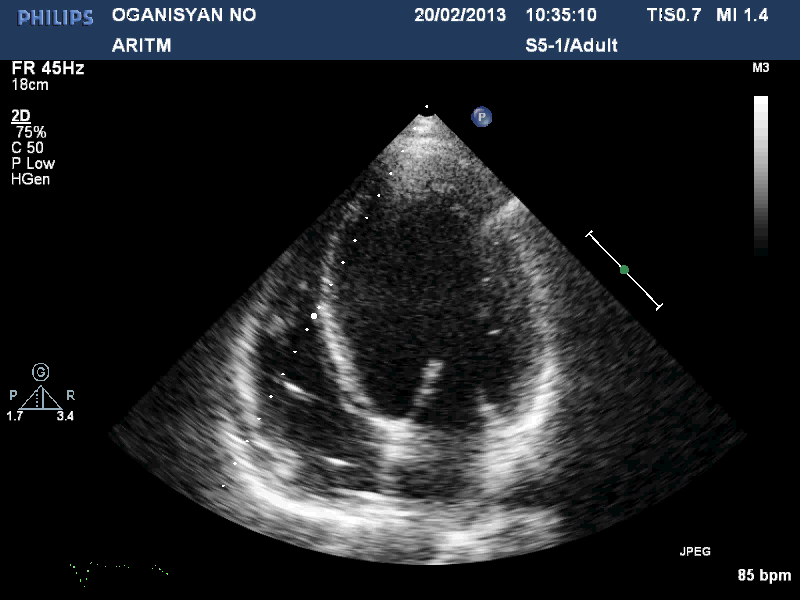

In [107]:
img, msk = data[0]
img

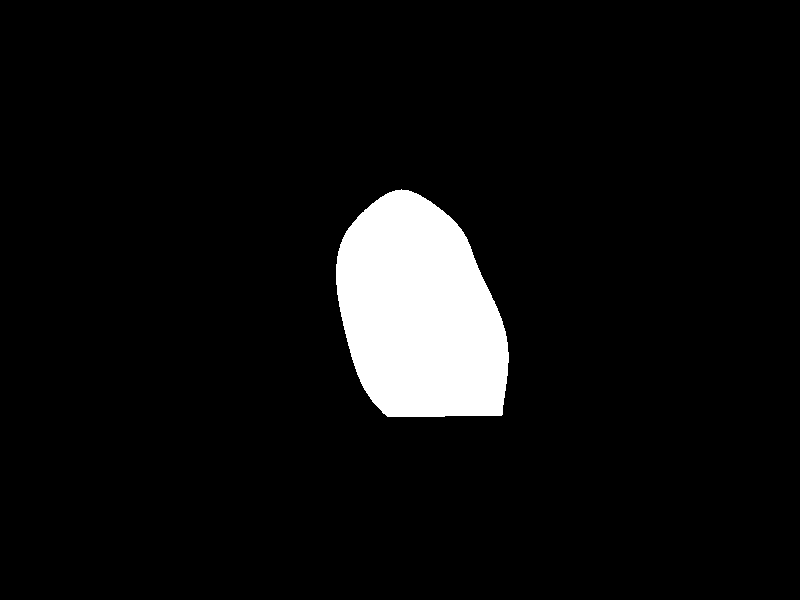

In [108]:
msk

In [114]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)
test_data = Dataset(path, subset='test', transform=T)

In [115]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False)

Используем модель Unet для сегментации снимков из библиотеки segmentation_models (https://github.com/qubvel/segmentation_models.pytorch).

In [153]:
import segmentation_models_pytorch as smp

model = smp.Unet().to(device)

Определяем функцию ошибки бинарную кроссэнтропию. Установи шаг обучения для энкодера и декодера сети, причем энкодер будет обучать медленнее.

In [154]:
from torch import nn 

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

In [155]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)


In [156]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou']:
#         max_score = valid_logs['iou']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 3/3 [00:00<00:00, 12.36it/s, bce_loss - 1.494, iou - 0.04984, f-score - 0.09486]

Epoch: 1
valid: 100%|██████████| 3/3 [00:00<00:00, 12.36it/s, bce_loss - 0.4333, iou - 0.3245, f-score - 0.4884]

Epoch: 2
valid: 100%|██████████| 3/3 [00:00<00:00, 12.34it/s, bce_loss - 0.3076, iou - 0.6805, f-score - 0.8096]

Epoch: 3
valid: 100%|██████████| 3/3 [00:00<00:00, 12.19it/s, bce_loss - 0.2985, iou - 0.6352, f-score - 0.7748]

Epoch: 4
valid: 100%|██████████| 3/3 [00:00<00:00, 12.22it/s, bce_loss - 0.2407, iou - 0.6909, f-score - 0.8161]

Epoch: 5
valid: 100%|██████████| 3/3 [00:00<00:00, 12.30it/s, bce_loss - 0.1912, iou - 0.7396, f-score - 0.8503]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 3/3 [00:00<00:00, 12.29it/s, bce_loss - 0.1828, iou - 0.7566, f-score - 0.8614]

Epoch: 7
valid: 100%|██████████| 3/3 [00:00<00:00, 12.22it/s, bce_loss - 0.1799, iou - 0.764, f-score - 0.8661]

Epoch: 8
valid: 100%|██████████| 3/3 [00:00<00:

In [157]:
valid_epoch.run(test_loader)

valid: 100%|██████████| 19/19 [00:00<00:00, 80.85it/s, bce_loss - 0.1771, iou - 0.7739, f-score - 0.8687]


{'bce_loss': 0.177117982977315,
 'iou': 0.773931423300191,
 'f-score': 0.8686678440947282}

Максимальное значение на валидации iou метрики - 77% и f-score - 87%. На тесте iou - 77%, f-score - 86%.

Возьмем другую функцию ошибки Dice и построим модель сегментации.

In [158]:
model = smp.Unet().to(device)

loss = smp.utils.losses.BCEDiceLoss(eps=1.)

metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [159]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou']:
#         max_score = valid_logs['iou']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 3/3 [00:00<00:00, 12.33it/s, bce_dice_loss - 1.557, iou - 0.1065, f-score - 0.1919]

Epoch: 1
valid: 100%|██████████| 3/3 [00:00<00:00, 12.33it/s, bce_dice_loss - 1.171, iou - 0.4061, f-score - 0.5748]

Epoch: 2
valid: 100%|██████████| 3/3 [00:00<00:00, 12.17it/s, bce_dice_loss - 0.9135, iou - 0.6567, f-score - 0.7921]

Epoch: 3
valid: 100%|██████████| 3/3 [00:00<00:00, 11.93it/s, bce_dice_loss - 0.7996, iou - 0.7627, f-score - 0.8653]

Epoch: 4
valid: 100%|██████████| 3/3 [00:00<00:00, 11.41it/s, bce_dice_loss - 0.7625, iou - 0.6978, f-score - 0.8219]

Epoch: 5
valid: 100%|██████████| 3/3 [00:00<00:00, 11.76it/s, bce_dice_loss - 0.7459, iou - 0.7067, f-score - 0.8279]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 3/3 [00:00<00:00, 12.15it/s, bce_dice_loss - 0.7263, iou - 0.754, f-score - 0.8597] 

Epoch: 7
valid: 100%|██████████| 3/3 [00:00<00:00, 12.33it/s, bce_dice_loss - 0.7227, iou - 0.7755, f-score - 0.8736]

Epoch: 8


In [160]:
valid_epoch.run(test_loader)

valid: 100%|██████████| 19/19 [00:00<00:00, 80.22it/s, bce_dice_loss - 0.6911, iou - 0.784, f-score - 0.8768]


{'bce_dice_loss': 0.6910811725415682,
 'iou': 0.7840447645438343,
 'f-score': 0.8768002077152854}

Максимальное значение на валидации iou метрики - 79% и f-score - 88%. На тесте iou - 78%, f-score - 88%.

In [188]:
import torch.nn.functional as F

img, mask_true = test_data[0]
mask_pred = F.sigmoid(model(img.unsqueeze(0).to(device)))

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


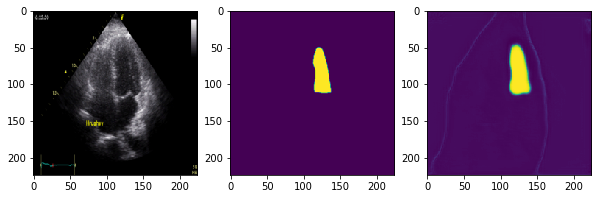

In [189]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(mask_true.squeeze().numpy())
plt.subplot(133)
plt.imshow(mask_pred.squeeze().cpu().detach().numpy())

## Задача

Натренировать Unet для сегментации людей на изображении. Использовать датасет 'person segmentation' по ссылке https://drive.google.com/open?id=1yi7Flk_Whidr2OZNdfmGkpgxbQPwIVtr.
Натрениройте несколько моделей Unet с различными энкодерами, проведите анализ качества полученных моделей. Сведите результаты в таблицу по всем моделям и для каждой подвиборке (train, valid, test). Приведите примеры кадров с людьми.